In [2]:
# -----------------------------------
# 1. Install and Import Packages
# -----------------------------------
import ee
import geemap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ML/DL Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

# -----------------------------------
# 2. Authenticate & Initialize EE
# -----------------------------------
ee.Authenticate()
ee.Initialize(project='gee-trial2') # Pass the project ID here

# -----------------------------------
# 3. Define AOI and Timeframe
# -----------------------------------
AOI = ee.Geometry.Polygon(
    [[[73.25239279892702, 18.996516438707232],
      [73.25239279892702, 18.340798678262793],
      [74.0969667735364, 18.340798678262793],
      [74.0969667735364, 18.996516438707232]]])

time_start = '2023-01-01'
time_end = '2023-12-31'

# -----------------------------------
# 4. Extract Features from GEE
# -----------------------------------

# Slope
dem = ee.Image("USGS/SRTMGL1_003").clip(AOI)
slope = ee.Terrain.slope(dem).rename('Slope')

# NDVI
s2 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
    .filterBounds(AOI) \
    .filterDate(time_start, time_end) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10)) \
    .select(['B8', 'B4']) \
    .median() \
    .clip(AOI)
ndvi = s2.normalizedDifference(['B8', 'B4']).rename('NDVI')

# Soil Moisture (Sentinel-1)
sentinel1 = ee.ImageCollection("COPERNICUS/S1_GRD") \
    .filterBounds(AOI) \
    .filterDate(time_start, time_end) \
    .filter(ee.Filter.eq('instrumentMode', 'IW')) \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
    .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING')) \
    .select(['VV', 'VH']) \
    .median() \
    .clip(AOI)

soil_moisture = sentinel1.expression(
    '(VH - VV) / (VH + VV)',
    {'VH': sentinel1.select('VH'), 'VV': sentinel1.select('VV')}
).rename('SoilMoisture')

# Precipitation (CHIRPS)
precipitation = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY") \
    .filterBounds(AOI) \
    .filterDate(time_start, time_end) \
    .sum() \
    .rename('Precipitation') \
    .clip(AOI)

# -----------------------------------
# 5. Normalize Features
# -----------------------------------
norm_slope = slope.divide(60)
norm_ndvi = ndvi.multiply(-1).add(1)
norm_soil = soil_moisture.add(1).divide(2)
norm_precip = precipitation.divide(3000)

# Stack all features
features = norm_slope.addBands([norm_ndvi, norm_soil, norm_precip])

# Sample data for ML
sample_points = features.sample(region=AOI, scale=30, numPixels=5000, seed=42).getInfo()
data = pd.DataFrame([f['properties'] for f in sample_points['features']])
X = data[['Slope', 'NDVI', 'SoilMoisture', 'Precipitation']].values

# For demonstration, let's generate a synthetic Landslide Risk label
# In practice, use real observed landslide data
y = (0.4*X[:,0] + 0.2*X[:,1] + 0.2*X[:,2] + 0.2*X[:,3])

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -----------------------------------
# 6. XGBoost Model
# -----------------------------------
xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))

# -----------------------------------
# 7. CNN Model (Simple Dense + Conv1D style for tabular features)
# -----------------------------------
# Reshape for CNN (samples, features, 1)
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

cnn_model = Sequential([
    Conv2D(16, kernel_size=(2,1), activation='relu', input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2], 1)),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1)
])

cnn_model.compile(optimizer='adam', loss='mse')
cnn_model.fit(X_train_cnn[..., np.newaxis], y_train, epochs=50, batch_size=32, verbose=0)
y_pred_cnn = cnn_model.predict(X_test_cnn[..., np.newaxis])
print("CNN RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_cnn)))

# -----------------------------------
# 8. Export Landslide Risk Map (Optional)
# -----------------------------------
# Compute landslide risk map using weighted formula (same as JS code)
landslide_risk = norm_slope.multiply(0.4).add(norm_ndvi.multiply(0.2)).add(norm_soil.multiply(0.2)).add(norm_precip.multiply(0.2))
geemap.ee_export_image(landslide_risk, filename='landslide_risk.tif', scale=30, region=AOI)

XGBoost RMSE: 0.041993119157971


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
CNN RMSE: 0.000758023056134735
Generating URL ...
An error occurred while downloading.
Total request size (68731740 bytes) must be less than or equal to 50331648 bytes.


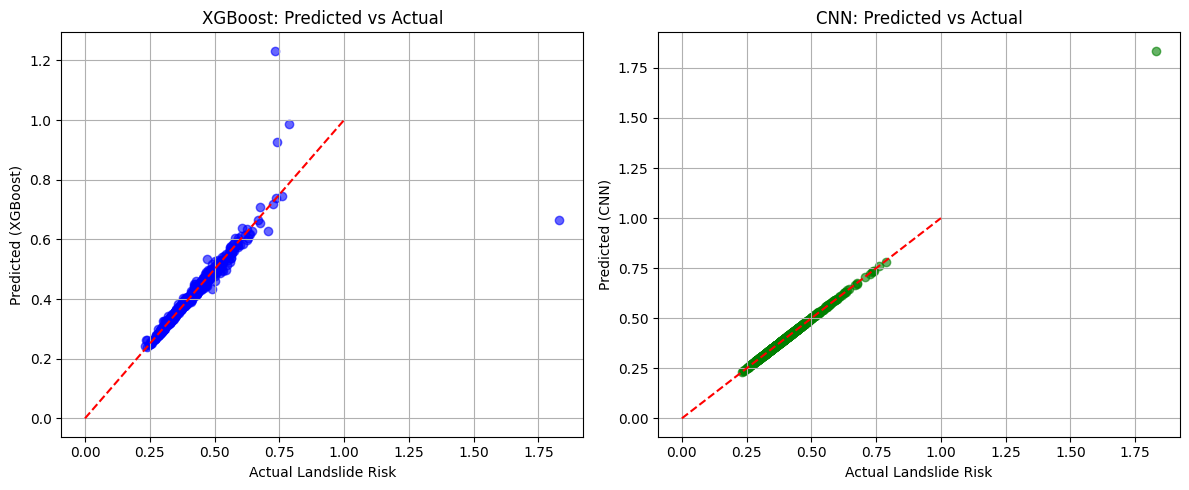

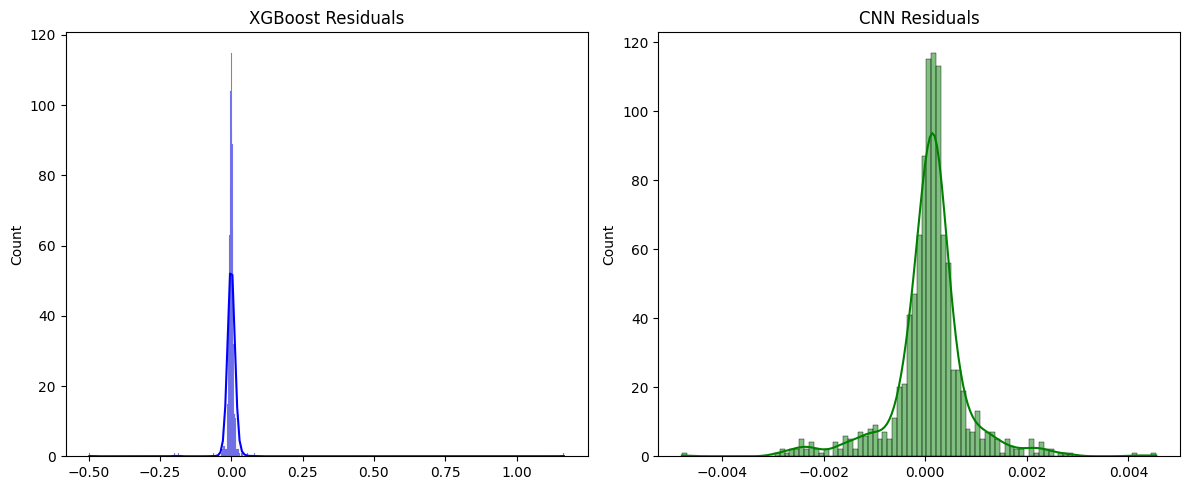

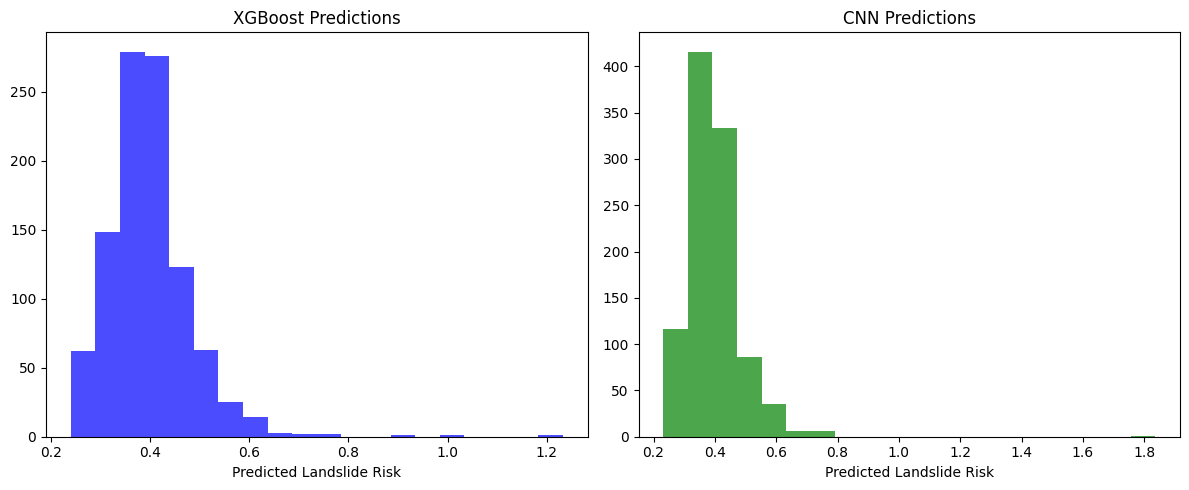

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# -----------------------------------
# 1. Predicted vs Actual (Scatter Plot)
# -----------------------------------
plt.figure(figsize=(12,5))

# XGBoost
plt.subplot(1,2,1)
plt.scatter(y_test, y_pred_xgb, alpha=0.6, color='blue')
plt.plot([0,1],[0,1], 'r--')
plt.xlabel('Actual Landslide Risk')
plt.ylabel('Predicted (XGBoost)')
plt.title('XGBoost: Predicted vs Actual')
plt.grid(True)

# CNN
plt.subplot(1,2,2)
plt.scatter(y_test, y_pred_cnn, alpha=0.6, color='green')
plt.plot([0,1],[0,1], 'r--')
plt.xlabel('Actual Landslide Risk')
plt.ylabel('Predicted (CNN)')
plt.title('CNN: Predicted vs Actual')
plt.grid(True)

plt.tight_layout()
plt.show()

# -----------------------------------
# 2. Residual Plot
# -----------------------------------
residual_xgb = y_test - y_pred_xgb
residual_cnn = y_test - y_pred_cnn.flatten()

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.histplot(residual_xgb, kde=True, color='blue')
plt.title('XGBoost Residuals')

plt.subplot(1,2,2)
sns.histplot(residual_cnn, kde=True, color='green')
plt.title('CNN Residuals')

plt.tight_layout()
plt.show()

# -----------------------------------
# 3. Histogram of Predictions
# -----------------------------------
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(y_pred_xgb, bins=20, color='blue', alpha=0.7)
plt.title('XGBoost Predictions')
plt.xlabel('Predicted Landslide Risk')

plt.subplot(1,2,2)
plt.hist(y_pred_cnn, bins=20, color='green', alpha=0.7)
plt.title('CNN Predictions')
plt.xlabel('Predicted Landslide Risk')

plt.tight_layout()
plt.show()


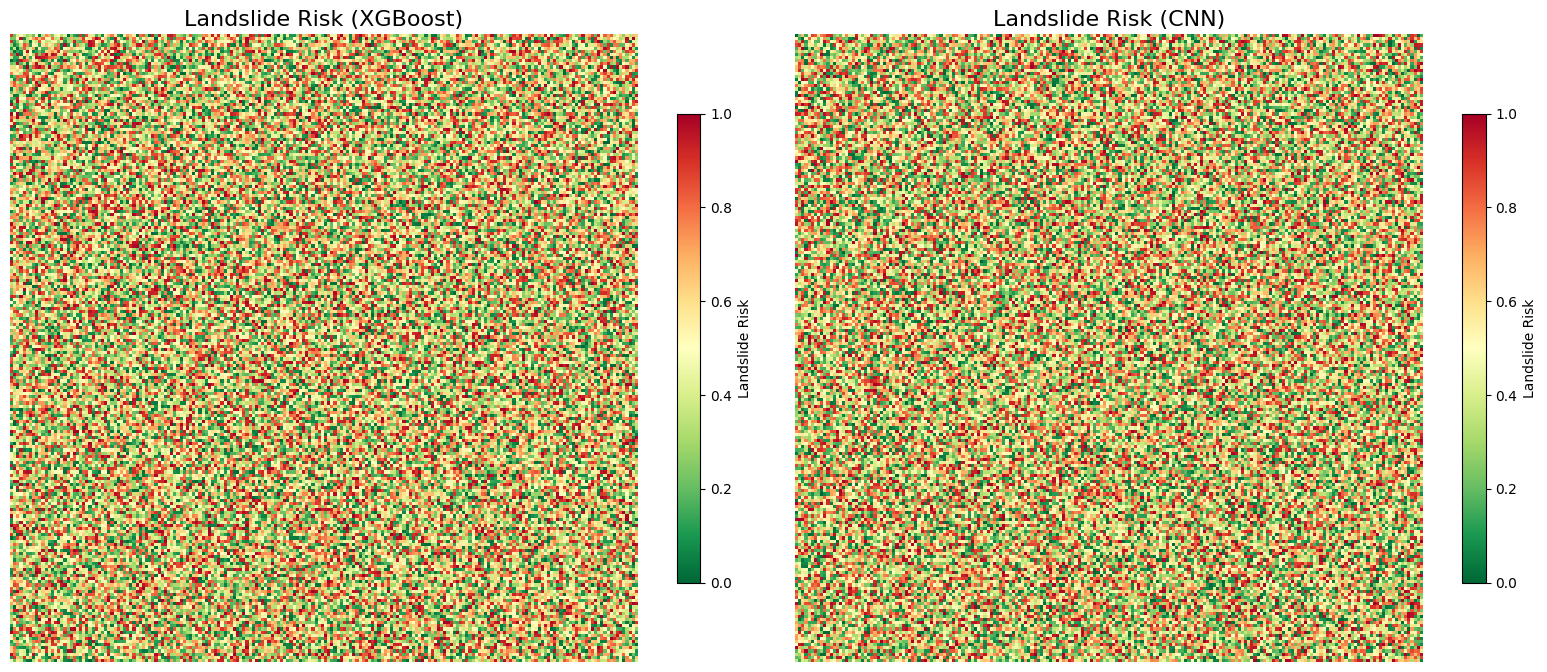

landslide_risk_comparison.png saved successfully!


In [33]:
import matplotlib.pyplot as plt
import numpy as np

def plot_compare_landslide(risk_xgb, risk_cnn, filename):
    # Check arrays
    if not isinstance(risk_xgb, np.ndarray) or not isinstance(risk_cnn, np.ndarray):
        raise ValueError("risk_xgb and risk_cnn must be NumPy arrays")
    if risk_xgb.ndim != 2 or risk_cnn.ndim != 2:
        raise ValueError("risk_xgb and risk_cnn must be 2D arrays")

    # Optional: normalize to 0-1 for consistent colormap
    risk_xgb_norm = (risk_xgb - np.min(risk_xgb)) / (np.max(risk_xgb) - np.min(risk_xgb))
    risk_cnn_norm = (risk_cnn - np.min(risk_cnn)) / (np.max(risk_cnn) - np.min(risk_cnn))

    plt.figure(figsize=(16,7))

    # XGBoost
    plt.subplot(1,2,1)
    plt.imshow(risk_xgb_norm, cmap='RdYlGn_r')
    plt.title("Landslide Risk (XGBoost)", fontsize=16)
    plt.axis('off')
    cbar = plt.colorbar(shrink=0.7)
    cbar.set_label('Landslide Risk')

    # CNN
    plt.subplot(1,2,2)
    plt.imshow(risk_cnn_norm, cmap='RdYlGn_r')
    plt.title("Landslide Risk (CNN)", fontsize=16)
    plt.axis('off')
    cbar = plt.colorbar(shrink=0.7)
    cbar.set_label('Landslide Risk')

    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()
    print(f"{filename} saved successfully!")

# ------------------------------
# Example usage with dummy data
# ------------------------------
height, width = 200, 200
y_pred_xgb_img = np.random.rand(height, width)   # replace with real XGBoost predictions
y_pred_cnn_img = np.random.rand(height, width)   # replace with real CNN predictions

plot_compare_landslide(y_pred_xgb_img, y_pred_cnn_img, "landslide_risk_comparison.png")
